# iscas_2026_1

## Setup

In [ ]:
!git clone https://github.com/leonardoLavagna/Iscas2025

In [ ]:
import os
os.chdir("Iscas2025")
!pip install -r requirements.txt

## Grover search as quantum walk

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit.result import marginal_counts
from qiskit.circuit.library import MCXGate, SwapGate
from qiskit.visualization import plot_histogram
from utilities.grover import simulate
from config import *
import numpy as np

In [4]:
def grover_diffusion_gate(n):
    """Grover diffuser on n qubits (reflection about uniform superposition |s>."""
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    # multi-controlled Z on the last qubit (about |11...1>)
    if n == 1:
        qc.z(0)
    else:
        qc.h(n-1)
        qc.append(MCXGate(n-1), list(range(n)))
        qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc.to_gate(label="Diff[coin]")

In [5]:
def phase_oracle_on_register(n_total, pos_start, pos_len, marked_bitstring):
    """
    Phase-flip oracle that acts only on the position register.
    n_total: total qubits in the circuit
    pos_start: starting index of position register in the circuit
    pos_len: number of qubits in the position register
    marked_bitstring: e.g. '101'
    """
    qc = QuantumCircuit(n_total)
    # Map MSB...LSB to Qiskit's little-endian order within the block
    bits = marked_bitstring[::-1]
    # X on zeros to turn |marked> into |11..1>
    for i, b in enumerate(bits):
        if b == '0':
            qc.x(pos_start + i)
    # Multi-controlled Z on position register
    if pos_len == 1:
        qc.z(pos_start)
    else:
        qc.h(pos_start + pos_len - 1)
        qc.append(MCXGate(pos_len - 1),
                  list(range(pos_start, pos_start + pos_len)))
        qc.h(pos_start + pos_len - 1)
    # Undo X
    for i, b in enumerate(bits):
        if b == '0':
            qc.x(pos_start + i)
    return qc.to_gate(label=f"Oracle|{marked_bitstring}>[pos]")


def flipflop_shift_swap(n, coin_start, pos_start):
    """Flip-flop shift S as a full SWAP between coin and position registers."""
    qc = QuantumCircuit(2*n)
    for i in range(n):
        qc.append(SwapGate(), [coin_start + i, pos_start + i])
    return qc.to_gate(label="Shift=SWAP")

In [6]:
def coined_grover_walk_search(n, marked_state, steps=None, measure=True):
    """
    Coined quantum walk Grover search on 2^n items.
    Registers: [coin (n qubits)] + [pos (n qubits)]
    Walk step: S * (C_coin ⊗ I_pos) * O_pos
    """
    N = 2**n
    n_total = 2*n
    coin_start = 0
    pos_start = n
    qc = QuantumCircuit(n_total, n_total if measure else 0)
    # Init to |s>_coin ⊗ |s>_pos
    qc.h(range(n_total))
    # Gates
    C_coin = grover_diffusion_gate(n)
    O_pos = phase_oracle_on_register(n_total, pos_start, n, marked_state)
    S_swap = flipflop_shift_swap(n, coin_start, pos_start)
    # Number of Grover-like steps
    if steps is None:
        steps = int(np.floor(np.pi/4*np.sqrt(N)))
    for _ in range(steps):
        qc.append(O_pos, range(n_total))
        qc.append(C_coin, range(coin_start, coin_start + n))
        qc.append(S_swap, range(n_total))
    if measure:
        qc.measure(range(n_total), range(n_total))
    return qc

In [7]:
def run_walk_and_get_position_counts(n, marked_state, backend=None, shots=2048):
    if backend is None:
        backend = Aer.get_backend("qasm_simulator")
    qc = coined_grover_walk_search(n, marked_state)
    qc = transpile(qc, backend)
    job = backend.run(qc, shots=shots)
    result = job.result()
    pos_counts = marginal_counts(result, indices=list(range(n, 2*n))).get_counts()
    return qc, pos_counts

Position register counts: {'1011': 83, '1001': 91, '1101': 72, '0010': 72, '1111': 60, '1100': 71, '0110': 66, '0111': 80, '0100': 74, '1110': 75, '0001': 61, '0000': 71, '0011': 61, '1010': 79, '1000': 74, '0101': 958}


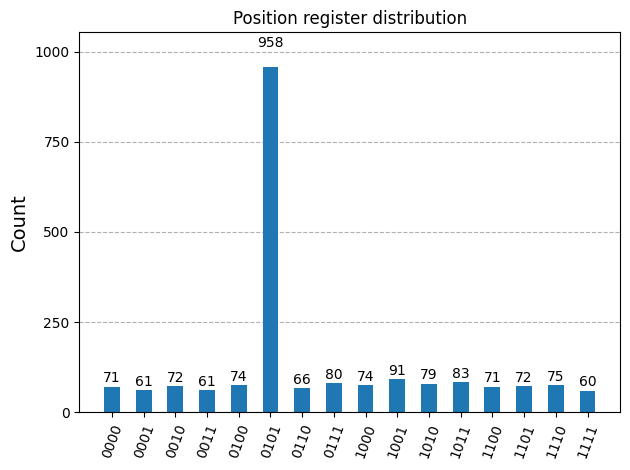

In [8]:
# Note: n>2
n = 4
marked_state = "0101"
qc, pos_counts = run_walk_and_get_position_counts(n, marked_state, shots=2048)
print("Position register counts:", pos_counts)
plot_histogram(pos_counts, title="Position register distribution")

## Cesar's cipher

In [9]:
ALPH = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
A2I = {c:i for i,c in enumerate(ALPH)}
I2A = {i:c for i,c in enumerate(ALPH)}

def clean_text(s): return "".join(ch for ch in s.upper() if ch in A2I)

def caesar_decrypt(ciphertext: str, key: int) -> str:
    c = clean_text(ciphertext)
    return "".join(I2A[(A2I[ch] - key) % 26] for ch in c)

def key_from_crib(plain_char: str, cipher_char: str) -> int:
    """Given one aligned P and C (A..Z), return k = (C - P) mod 26."""
    return (A2I[cipher_char.upper()] - A2I[plain_char.upper()]) % 26

def int_to_bits(x: int, n: int) -> str:
    return format(x, f"0{n}b")

## Quantum Walk-Grover attack against Cesar's cipher

In [10]:
def grover_walk_attack_caesar(ciphertext: str,
                              true_key: int = None,
                              crib_pair: tuple = None,
                              shots: int = 4096,
                              backend=backend):
    """
    Grover (coined-walk) attack on Caesar's cipher key space.
    You must provide either:
      - true_key (for simulation), OR
      - crib_pair = (P, C) one aligned plaintext/ciphertext letter (A..Z).
    Returns: measured key distribution (over 26), best key, and decrypted text with that key.
    """
    if true_key is None and crib_pair is None:
        raise ValueError("Provide either true_key for simulation or crib_pair=(P,C).")
    if crib_pair is not None:
        P, C = crib_pair
        k = key_from_crib(P, C)
    else:
        k = true_key % 26
    # Map key to 5-bit marked state
    n = 5
    marked_bits = int_to_bits(k, n)
    qc = coined_grover_walk_search(n, marked_bits)
    tqc = transpile(qc, backend)
    job = backend.run(tqc, shots=shots)
    result = job.result()
    # Position (= key) register is the last n qubits in our layout.
    pos_marg = marginal_counts(result, indices=list(range(n, 2*n))).get_counts()
    # Convert 5-bit outcomes to integers and aggregate only 0..25
    key_hist = {}
    for bitstr, cnt in pos_marg.items():
        key_int = int(bitstr, 2)
        if key_int < 26:
            key_hist[key_int] = key_hist.get(key_int, 0) + cnt
    # Pick best key
    best_key = max(key_hist, key=key_hist.get) if key_hist else None
    decrypted = caesar_decrypt(ciphertext, best_key) if best_key is not None else ""
    return {
        "key_hist_0_25": key_hist,
        "best_key": best_key,
        "decrypted_with_best": decrypted,
        "marked_key": k
    }

### Fault-tolerant case

In [14]:
from qiskit_aer import Aer

ct = "YMJ VZNHP GWTBS KTC OZRUX TAJW YMJ QFED ITL"
# Suppose we know one aligned pair (crib): plaintext 'T' corresponds to ciphertext 'Y'
# (this is just for demo; any aligned pair works)
backend = Aer.get_backend("qasm_simulator")
out = grover_walk_attack_caesar(ct, crib_pair=('T','Y'), shots=4096, backend=backend)
print("Marked (correct) key:", out["marked_key"])
print("Best key (Grover walk):", out["best_key"])
print("Decrypted:", out["decrypted_with_best"])

Marked (correct) key: 5
Best key (Grover walk): 5
Decrypted: THEQUICKBROWNFOXJUMPSOVERTHELAZYDOG


**Remark .** Resources needed
- One oracle call plus one diffusion (coin-shift) operation
- A Grover-type number of steps

thus resulting in $T=5\sim \sqrt{26}$ queries as expected.



### NISQ case

In the configuration file (config.py) change the backend to a noisy one.

In [15]:
def success_prob_for_steps(marked_key:int, steps:int, shots:int,
                           backend, n_key_qubits:int=5):
    marked_bits = format(marked_key, f"0{n_key_qubits}b")
    qc = coined_grover_walk_search(n_key_qubits, marked_bits, steps=steps)
    tqc = transpile(qc, backend)
    job = backend.run(tqc, shots=shots)
    result = job.result()
    # key register is the last n_key_qubits
    pos = marginal_counts(result, indices=list(range(n_key_qubits, 2*n_key_qubits))).get_counts()
    return pos.get(marked_bits, 0) / shots

In [16]:
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.noise import NoiseModel

fake = backend
noise_model = NoiseModel.from_backend(fake)
noisy_backend = AerSimulator(noise_model=noise_model,
                             basis_gates=noise_model.basis_gates,
                             coupling_map=fake.configuration().coupling_map)
ideal_backend = AerSimulator(method="statevector")

/usr/local/lib/python3.12/dist-packages/qiskit_aer/noise/noise_model.py:376: UserWarning: Qiskit backend QasmSimulator('qasm_simulator') has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


In [17]:
shots = 4096
marked_key = 5
ks = list(range(1, 26))
ideal = []
noisy = []
for k in ks:
    ideal.append(success_prob_for_steps(marked_key, k, shots, ideal_backend))
    noisy.append(success_prob_for_steps(marked_key, k, shots, noisy_backend))

print("Steps:", ks)
print("Ideal success:", [round(x,3) for x in ideal])
print("Noisy success:", [round(x,3) for x in noisy])

Steps: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Ideal success: [0.037, 0.266, 0.267, 0.618, 0.611, 0.895, 0.896, 0.999, 0.998, 0.851, 0.86, 0.55, 0.541, 0.211, 0.215, 0.016, 0.012, 0.061, 0.053, 0.309, 0.314, 0.656, 0.665, 0.935, 0.926]
Noisy success: [0.03, 0.252, 0.256, 0.591, 0.613, 0.896, 0.898, 0.999, 0.999, 0.858, 0.859, 0.545, 0.538, 0.201, 0.219, 0.012, 0.014, 0.05, 0.051, 0.314, 0.304, 0.655, 0.652, 0.932, 0.929]


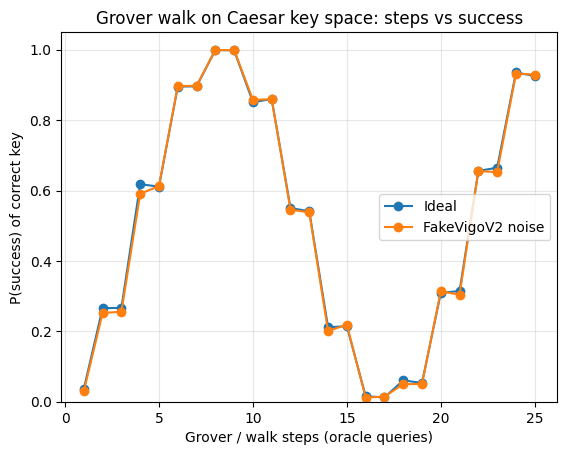

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(ks, ideal, marker='o', label='Ideal')
plt.plot(ks, noisy, marker='o', label='FakeVigoV2 noise')
plt.xlabel("Grover / walk steps (oracle queries)")
plt.ylabel("P(success) of correct key")
plt.title("Grover walk on Caesar key space: steps vs success")
plt.ylim(0,1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

This is a standard Grover-like periodic behaviour where we can see that the noisy backend had a limited impact.

#### Optimal steps and quantification of damping

In [19]:
from qiskit_aer.noise import depolarizing_error, ReadoutError

In [27]:
def sweep_success(marked_key:int, steps_list, shots, backend):
    return np.array([success_prob_for_steps(marked_key, k, shots, backend) for k in steps_list])

def first_two_peaks(xs, ys):
    # simple peak finder: y[i] is a peak if it's greater than neighbors
    peaks = []
    for i in range(1, len(ys)-1):
        if ys[i] >= ys[i-1] and ys[i] >= ys[i+1]:
            peaks.append((xs[i], ys[i]))
    return peaks[:2]

def estimate_kappa(peaks):
    if len(peaks) < 2:
        return np.nan
    (k1, p1), (k2, p2) = peaks[0], peaks[1]
    if p2 <= 0 or p1 <= p2:
        return np.nan
    return (k2 - k1) / np.log(p1 / p2)

def analyze_backend(backend, label, marked_key=5, steps_range=range(1, 15), shots=4096, N=26):
    xs = np.array(list(steps_range))
    ys = sweep_success(marked_key, xs, shots, backend)
    peaks = first_two_peaks(xs, ys)
    kappa = estimate_kappa(peaks)
    k_opt = xs[np.argmax(ys)]
    p_opt = np.max(ys)
    print(f"[{label}] optimal steps = {k_opt},  max success = {p_opt:.3f}")
    if len(peaks) >= 1:
        print(f"[{label}] first peak at k={peaks[0][0]} with p={peaks[0][1]:.3f}")
    if len(peaks) >= 2:
        print(f"[{label}] second peak at k={peaks[1][0]} with p={peaks[1][1]:.3f}")
    print(f"[{label}] estimated damping kappa ≈ {kappa:.2f}\n")
    return xs, ys, peaks, kappa, k_opt, p_opt

In [28]:
def simple_noise_model(n_qubits:int,
                       p1=1e-3, p2=5e-3, p_meas=2e-2):
    """
    Uniform depolarizing errors: 1q at p1, 2q at p2, and symmetric readout error p_meas.
    """
    nm = NoiseModel()
    # gate errors
    err1 = depolarizing_error(p1, 1)
    err2 = depolarizing_error(p2, 2)
    # add to common basis gates (adapted to transpiled basis)
    nm.add_all_qubit_quantum_error(err1, ['u1','u2','u3','rx','ry','rz'])
    nm.add_all_qubit_quantum_error(err2, ['cx'])
    # readout
    ro = ReadoutError([[1-p_meas, p_meas],[p_meas, 1-p_meas]])
    for q in range(n_qubits):
        nm.add_readout_error(ro, [q])
    return nm

def make_backend_with_noise(n_qubits:int, p1, p2, p_meas, coupling_map=None):
    nm = simple_noise_model(n_qubits, p1, p2, p_meas)
    return AerSimulator(noise_model=nm,
                        basis_gates=nm.basis_gates,
                        coupling_map=coupling_map)


In [29]:
# (we use 2*n with n=5 for the walk circuit)
nq = 10
# 0=noiseless, 2x noise, etc.
scales = [0.0, 0.5, 1.0, 2.0]
base = dict(p1=1e-3, p2=8e-3, p_meas=2e-2)
for s in scales:
    be = make_backend_with_noise(nq, s*base['p1'], s*base['p2'], s*base['p_meas'])
    analyze_backend(be, f"dep+ro scale {s}", marked_key=5, shots=512)

[dep+ro scale 0.0] optimal steps = 8,  max success = 0.998
[dep+ro scale 0.0] first peak at k=2 with p=0.242
[dep+ro scale 0.0] second peak at k=4 with p=0.645
[dep+ro scale 0.0] estimated damping kappa ≈ nan

[dep+ro scale 0.5] optimal steps = 4,  max success = 0.340
[dep+ro scale 0.5] first peak at k=4 with p=0.340
[dep+ro scale 0.5] second peak at k=7 with p=0.334
[dep+ro scale 0.5] estimated damping kappa ≈ 172.50

[dep+ro scale 1.0] optimal steps = 5,  max success = 0.160
[dep+ro scale 1.0] first peak at k=2 with p=0.143
[dep+ro scale 1.0] second peak at k=5 with p=0.160
[dep+ro scale 1.0] estimated damping kappa ≈ nan

[dep+ro scale 2.0] optimal steps = 3,  max success = 0.084
[dep+ro scale 2.0] first peak at k=3 with p=0.084
[dep+ro scale 2.0] second peak at k=5 with p=0.070
[dep+ro scale 2.0] estimated damping kappa ≈ 11.26



We can go to higher scales (more shots and steps). Essentially what we can see even here is that:
- The damping estimator given needs the second peak lower than the first ($p_1<p_2$) and some second peak is equal or very close and the log term blows up. This is expected looking at Grover oscillation.
- Noise dampens amplitude (max success probability decreases fast).
- Noise shifts optimal step earlier (oracle queries fewer than ideal)
- For Caesar (tiny N=26), only a couple of walk steps are worth executing under noise

In [30]:
from qiskit.transpiler import CouplingMap

line_10 = CouplingMap.from_line(10)
noisy_line = make_backend_with_noise(10, 1e-3, 8e-3, 2e-2, coupling_map=line_10)

#### A combined experiment: noise level and topology

In [38]:
def run_grid(n=5,
             scales=(0.0, 0.5, 1.0, 2.0),
             base=dict(p1=1e-3, p2=8e-3, p_meas=2e-2),
             coupling_map=None,
             shots=1024,
             steps_range=range(1, 9)):
    """
    Sweep noise scales for a Grover-walk Caesar attack.
    Ensures nq=2*n qubits and applies an initial_layout to match the device map.
    """
    nq = 2 * n
    stats = []
    for s in scales:
        be = make_backend_with_noise(
            nq,
            s*base['p1'],
            s*base['p2'],
            s*base['p_meas'],
            coupling_map=coupling_map
        )
        # Use forced initial_layout inside analyze_backend
        xs, ys, peaks, kappa, k_opt, p_opt = analyze_backend(
            be,
            f"scale {s}",
            marked_key=5,
            steps_range=steps_range,
            shots=shots,
            N=26,
            initial_layout=list(range(nq))   # <--- force mapping
        )
        stats.append(dict(scale=s,
                          k_opt=k_opt,
                          p_opt=p_opt,
                          kappa=kappa))
    return stats

In [39]:
def analyze_backend(backend, label, marked_key=5,
                    steps_range=range(1, 26),
                    shots=4096, N=26,
                    initial_layout=None):
    xs = np.array(list(steps_range))
    ys = []
    for k in xs:
        qc = coined_grover_walk_search(5, format(marked_key, "05b"), steps=k)
        tqc = transpile(qc, backend,
                        initial_layout=initial_layout,
                        optimization_level=3)
        job = backend.run(tqc, shots=shots)
        result = job.result()
        pos = marginal_counts(result, indices=list(range(5, 10))).get_counts()
        ys.append(pos.get(format(marked_key, "05b"), 0) / shots)
    ys = np.array(ys)
    peaks = first_two_peaks(xs, ys)
    kappa = estimate_kappa(peaks)
    k_opt = xs[np.argmax(ys)]
    p_opt = np.max(ys)
    print(f"[{label}] optimal steps = {k_opt},  max success = {p_opt:.3f}")
    if len(peaks) >= 1:
        print(f"[{label}] first peak at k={peaks[0][0]} with p={peaks[0][1]:.3f}")
    if len(peaks) >= 2:
        print(f"[{label}] second peak at k={peaks[1][0]} with p={peaks[1][1]:.3f}")
    print(f"[{label}] estimated damping kappa ≈ {kappa}\n")
    return xs, ys, peaks, kappa, k_opt, p_opt

In [40]:
dense_stats = run_grid(n=5)
print("Dense:", dense_stats)

[scale 0.0] optimal steps = 8,  max success = 0.998
[scale 0.0] first peak at k=2 with p=0.271
[scale 0.0] second peak at k=4 with p=0.602
[scale 0.0] estimated damping kappa ≈ nan

[scale 0.5] optimal steps = 6,  max success = 0.345
[scale 0.5] first peak at k=2 with p=0.175
[scale 0.5] second peak at k=4 with p=0.312
[scale 0.5] estimated damping kappa ≈ nan

[scale 1.0] optimal steps = 5,  max success = 0.184
[scale 1.0] first peak at k=2 with p=0.119
[scale 1.0] second peak at k=5 with p=0.184
[scale 1.0] estimated damping kappa ≈ nan

[scale 2.0] optimal steps = 2,  max success = 0.086
[scale 2.0] first peak at k=2 with p=0.086
[scale 2.0] second peak at k=4 with p=0.073
[scale 2.0] estimated damping kappa ≈ 12.51183142693782

Dense: [{'scale': 0.0, 'k_opt': np.int64(8), 'p_opt': np.float64(0.998046875), 'kappa': nan}, {'scale': 0.5, 'k_opt': np.int64(6), 'p_opt': np.float64(0.3447265625), 'kappa': nan}, {'scale': 1.0, 'k_opt': np.int64(5), 'p_opt': np.float64(0.18359375), 'kappa'

The point is: the noise level can be either "too much" or "too little" given the optimal number of steps (and a topology of qubit connectivity).

In [41]:
def plot_stats(stats, title):
    scales = [d['scale'] for d in stats]
    p_opts = [d['p_opt'] for d in stats]
    k_opts = [d['k_opt'] for d in stats]
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel("Noise scale")
    ax1.set_ylabel("Max success probability", color=color)
    ax1.plot(scales, p_opts, marker='o', color=color, label="Max success")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0, 1.05)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel("Optimal steps", color=color)
    ax2.plot(scales, k_opts, marker='s', color=color, label="Optimal steps")
    ax2.tick_params(axis='y', labelcolor=color)
    plt.title(title)
    fig.tight_layout()
    plt.show()

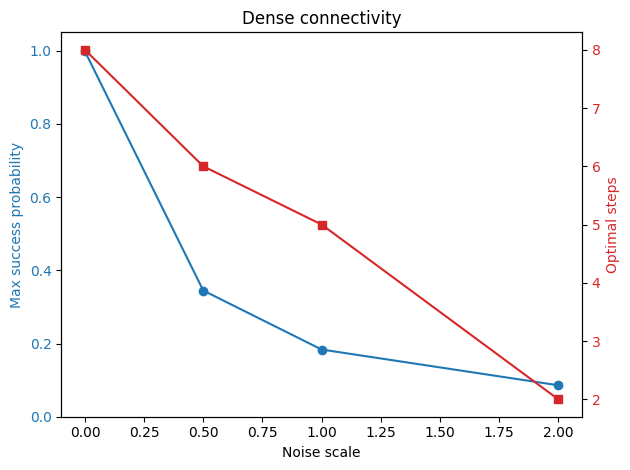

In [42]:
plot_stats(dense_stats, "Dense connectivity")

In the noiseless regime, the coined Grover walk achieves nearly unit success probability at the predicted number of steps. As we increase the depolarizing and readout noise rates, the amplification peak both lowers and shifts to earlier iterations. For Caesar’s 26-key space, the optimal number of oracle queries drops from 7-8 in the ideal case to only 2-3 under 2x realistic noise, with maximum success probability falling below 10%